In [308]:
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import numpy as np # linear algebra
import pandas as pd

### Necessary sklearn api for analysis and model training

In [309]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler,MaxAbsScaler,OneHotEncoder,PolynomialFeatures,OrdinalEncoder

from sklearn.impute import SimpleImputer,KNNImputer

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import ShuffleSplit,train_test_split,GridSearchCV,cross_val_score,RepeatedKFold,cross_validate

from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression,RidgeCV,LassoCV,SGDRegressor,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.neural_network import MLPRegressor

from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectKBest,f_regression

### Importing the training and test data

In [310]:
data=pd.read_csv('/content/train.csv')
test_data=pd.read_csv('/content/test.csv')

In [311]:
np.random.seed(306)

# EDA

In [312]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2023-06-28 17:20:21,2023-06-28 16:34:45,1.0,2.14,1.0,N,120,9,Credit Card,2.5,7.165589,0.0,1.0,20.64,2.5,0.0
1,0,2023-06-29 23:05:01,2023-06-29 22:01:35,1.0,2.70,1.0,N,15,215,Credit Card,3.5,6.067401,0.0,1.0,25.55,2.5,0.0
2,1,2023-06-30 10:19:31,2023-06-30 11:13:10,1.0,1.15,1.0,N,167,223,Credit Card,0.0,4.111547,0.0,1.0,17.64,2.5,0.0
3,0,2023-06-29 13:23:09,2023-06-29 14:20:01,1.0,0.40,1.0,N,128,239,Credit Card,2.5,6.411079,0.0,1.0,12.80,2.5,0.0
4,1,2023-06-29 22:03:32,2023-06-29 22:22:22,3.0,1.10,1.0,N,203,52,Credit Card,1.0,4.769377,0.0,1.0,18.00,2.5,0.0


In [313]:
data.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
count,175000.000000,168923.000000,175000.000000,168923.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,168923.000000,168923.000000
mean,0.728377,1.357678,5.145930,1.518307,132.710349,132.701429,1.932143,6.127497,0.646816,0.979689,29.633901,2.246971,0.158825
std,0.445606,0.891283,394.971052,6.514678,76.148799,76.192493,1.948497,4.610834,2.328274,0.198775,25.425206,0.819216,0.511968
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,-7.500000,0.000079,-29.300000,-1.000000,-576.750000,-2.500000,-1.750000
25%,0.000000,1.000000,1.080000,1.000000,67.000000,67.000000,0.000000,3.473321,0.000000,1.000000,16.300000,2.500000,0.000000
50%,1.000000,1.000000,1.840000,1.000000,133.000000,133.000000,1.000000,5.286217,0.000000,1.000000,21.450000,2.500000,0.000000
75%,1.000000,1.000000,3.610000,1.000000,199.000000,199.000000,2.500000,7.502746,0.000000,1.000000,31.800000,2.500000,0.000000
max,2.000000,9.000000,135182.060000,99.000000,264.000000,264.000000,11.750000,484.876151,80.000000,1.000000,587.250000,2.500000,1.750000


<Axes: ylabel='total_amount'>

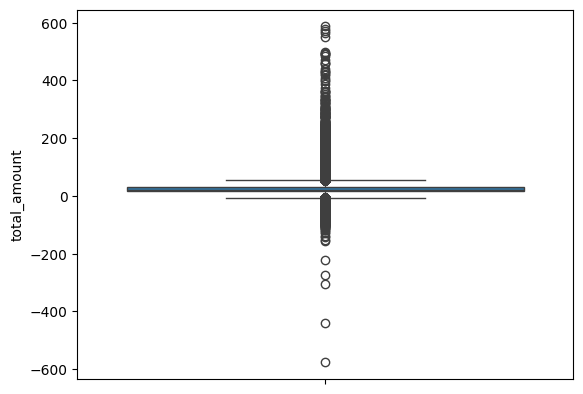

In [314]:
sns.boxplot(data['total_amount'],)

* Trip distance,tip amount,tolls amount,total amount has large outliers (which could be due to due to error in data entrying)

In [315]:
data.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'extra', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'Airport_fee'],
      dtype='object')

In [316]:
test_data.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'extra', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'congestion_surcharge',
       'Airport_fee'],
      dtype='object')

In [317]:
# function to extract travel duration in minutes from the pickup and drop off date time

def datetime_to_min(dat):
    dat['tpep_pickup_datetime']=pd.to_datetime(dat['tpep_pickup_datetime'])
    dat['tpep_dropoff_datetime']=pd.to_datetime(dat['tpep_dropoff_datetime'])

    dat['Day'] = dat['tpep_pickup_datetime'].dt.dayofweek
    dat['Hour'] = dat['tpep_pickup_datetime'].dt.hour
    dat['min'] = dat['tpep_pickup_datetime'].dt.minute

    #day,hour and min for pickup are converted into minutes
    dat['pickup_in_min']=dat['Day']*24*60+dat['Hour']*60+dat['min']

    dat['Day_d'] = dat['tpep_dropoff_datetime'].dt.dayofweek
    dat['Hour_d'] = dat['tpep_dropoff_datetime'].dt.hour
    dat['min_d'] = dat['tpep_dropoff_datetime'].dt.minute

    #day,hour and min for drop off are converted into minutes
    dat['dropoff_in_min']=dat['Day_d']*24*60+dat['Hour_d']*60+dat['min_d']
    #duration=drop off - pickup
    dat['duration_in_min']=np.abs(dat['dropoff_in_min']-dat['pickup_in_min'])

    del_col=['pickup_in_min', 'Day_d', 'Hour_d','min','min_d',
             'dropoff_in_min','tpep_pickup_datetime','tpep_dropoff_datetime',]
    dat=dat.drop(columns=del_col,axis=1)
    return (dat)



In [318]:
data_t=datetime_to_min(data)
test_data_t=datetime_to_min(test_data)


In [319]:
#correlation of attributes with the label
co_mat=data_t.corr(numeric_only=True,method='spearman')
co_mat['total_amount']

VendorID                 0.053342
passenger_count          0.067197
trip_distance            0.862276
RatecodeID               0.360196
PULocationID            -0.002626
DOLocationID            -0.004341
extra                    0.151971
tip_amount               0.510452
tolls_amount             0.470804
improvement_surcharge    0.162988
total_amount             1.000000
congestion_surcharge    -0.120613
Airport_fee              0.446505
Day                     -0.049855
Hour                     0.050493
duration_in_min          0.100177
Name: total_amount, dtype: float64

* trip distance is the single most important attribute on determining the total amount followed by tip amount,tolls amount,airport fee etc.
* surprisingly passanger count and duration of the ride have very less dependency on the total amount.
* Location id's are redundant.

<Axes: >

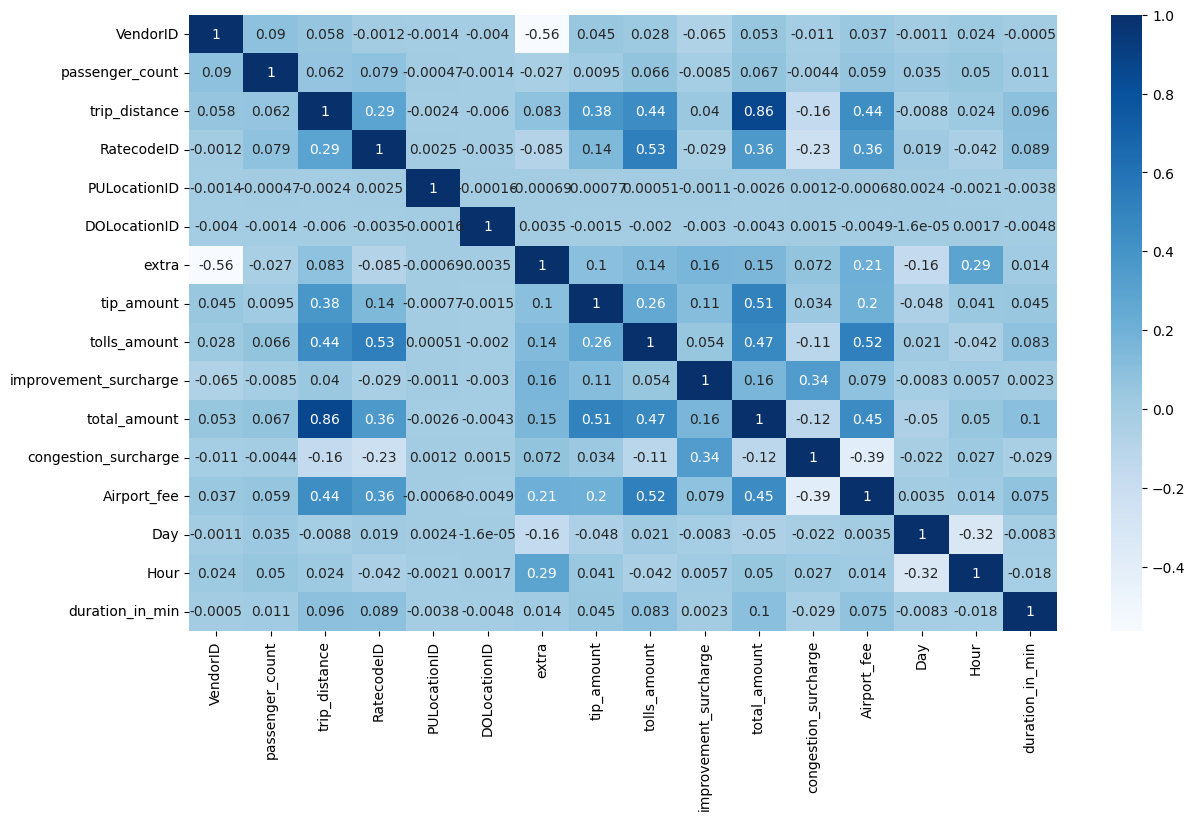

In [320]:
plt.figure(figsize=(14,8))
sns.heatmap(data=co_mat,cmap='Blues',annot=True)

In [321]:
# deleting redudant attribures
del_col=[
         'PULocationID','DOLocationID','store_and_fwd_flag','passenger_count'
         ]

data_t.drop(columns=del_col,axis=1,inplace=True)
test_data_t.drop(columns=del_col,axis=1,inplace=True)

In [322]:
data_t.info()
# split features into numerical and categorical
num_col = list(data_t.select_dtypes("number").columns)
cat_col = list(data_t.select_dtypes(exclude = "number").columns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175000 entries, 0 to 174999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               175000 non-null  int64  
 1   trip_distance          175000 non-null  float64
 2   RatecodeID             168923 non-null  float64
 3   payment_type           175000 non-null  object 
 4   extra                  175000 non-null  float64
 5   tip_amount             175000 non-null  float64
 6   tolls_amount           175000 non-null  float64
 7   improvement_surcharge  175000 non-null  float64
 8   total_amount           175000 non-null  float64
 9   congestion_surcharge   168923 non-null  float64
 10  Airport_fee            168923 non-null  float64
 11  Day                    175000 non-null  int64  
 12  Hour                   175000 non-null  int64  
 13  duration_in_min        175000 non-null  int64  
dtypes: float64(9), int64(4), object(1)
m

### A small sample set to do EDA
 As the population set could make out to be too large to handle we are creating a small sample set consisting of 30,000 samples which is a representation of the population set

In [323]:
#A subset of data for EDA
shuffle_indices=np.random.permutation(30000)
#shuffle_indices[:10]
data_eval=data.iloc[shuffle_indices]

#### A scatterplot analysis of all the features with the label

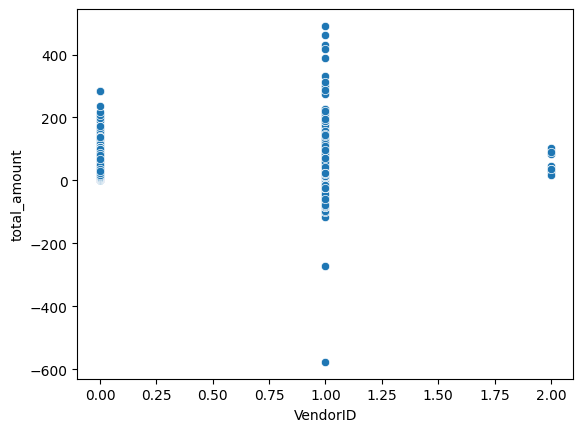

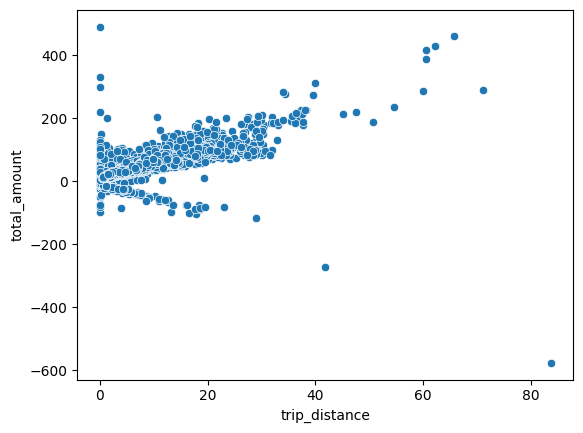

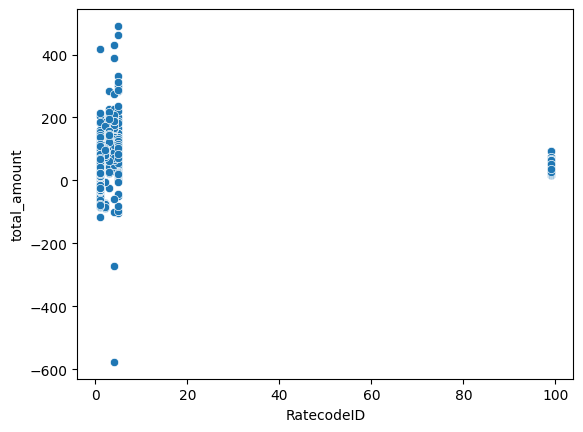

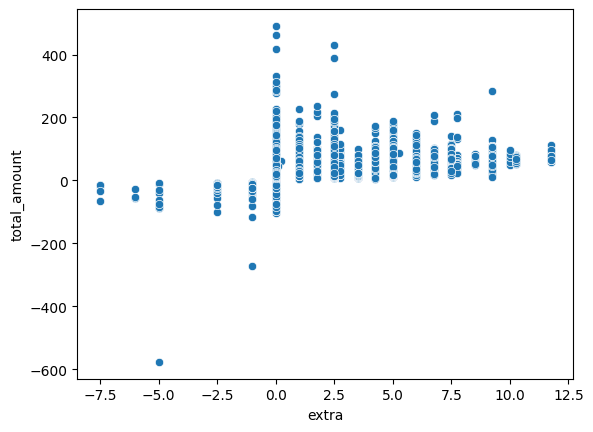

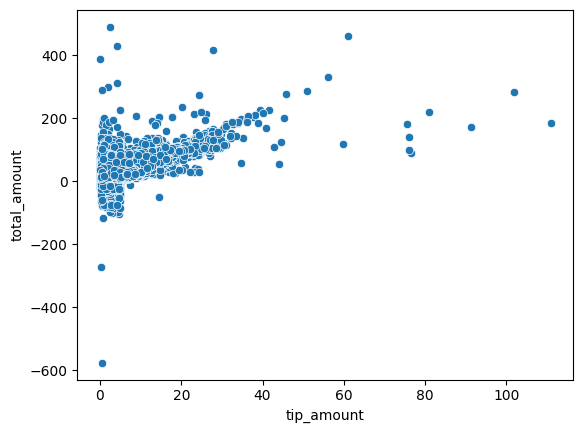

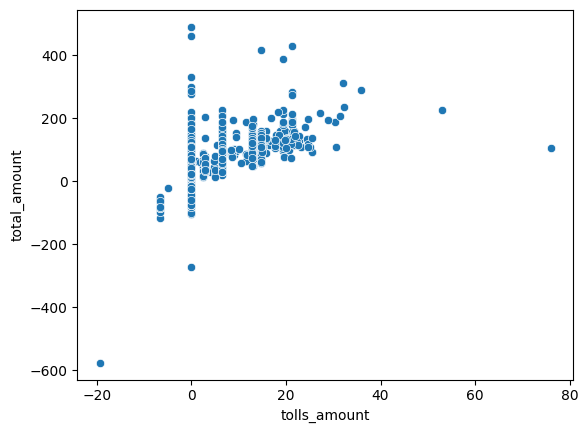

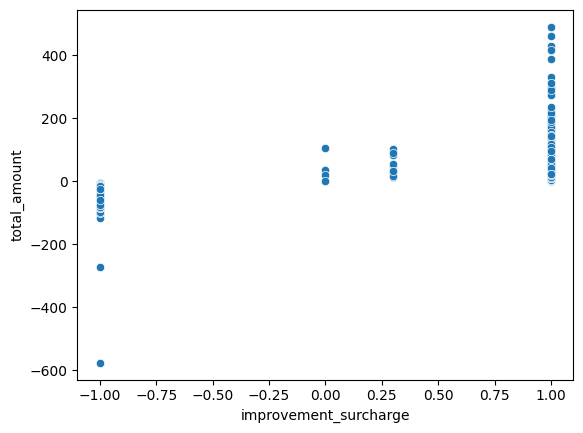

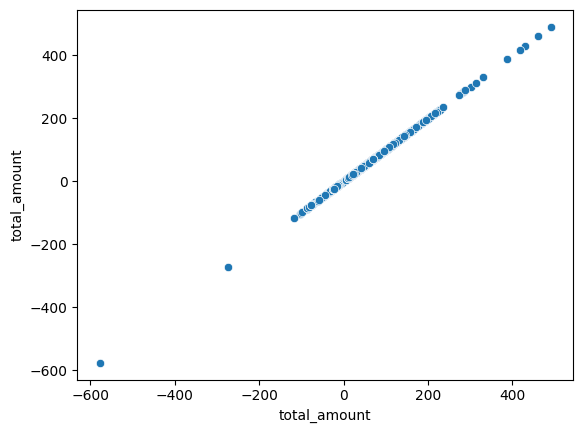

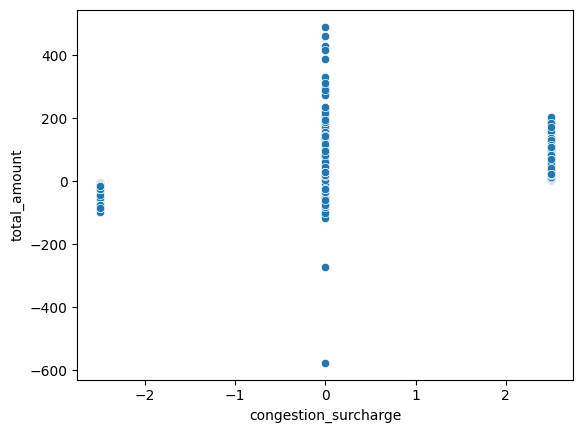

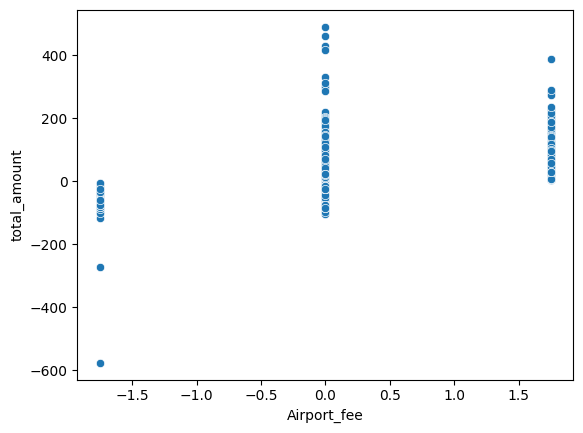

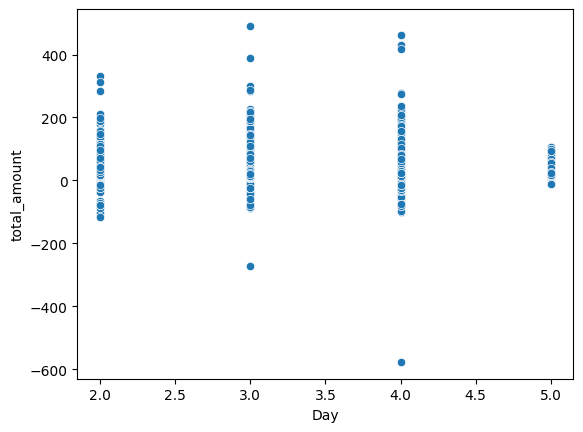

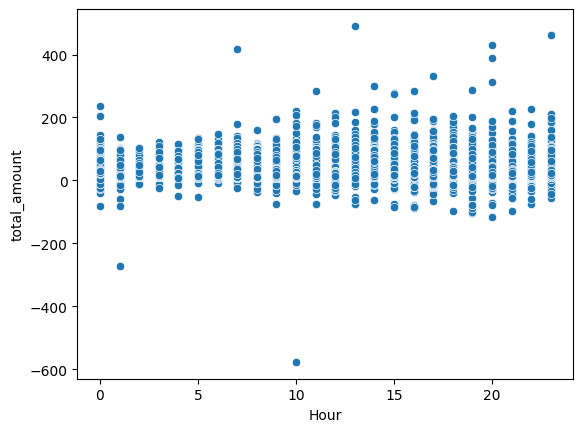

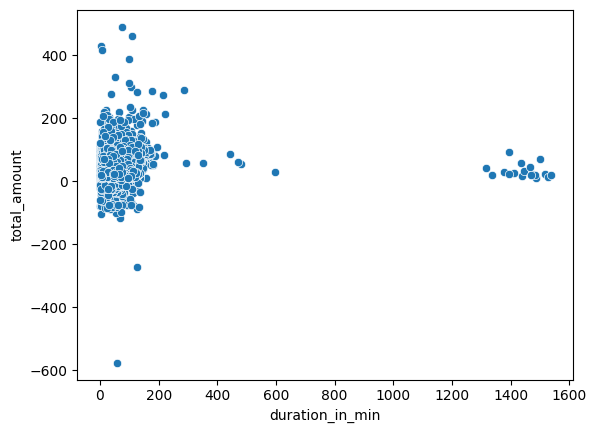

In [324]:
for i in num_col:
    sns.scatterplot(data=data_eval,x=data_eval[i],y='total_amount')
    plt.show();

#### Observations :
* Trip distance,Tip amount,tolls amount,improvement surcharge is highly correlated with total amount
* higher no of passengers seems to have paid lower amount


#### Histogram of all the attributes

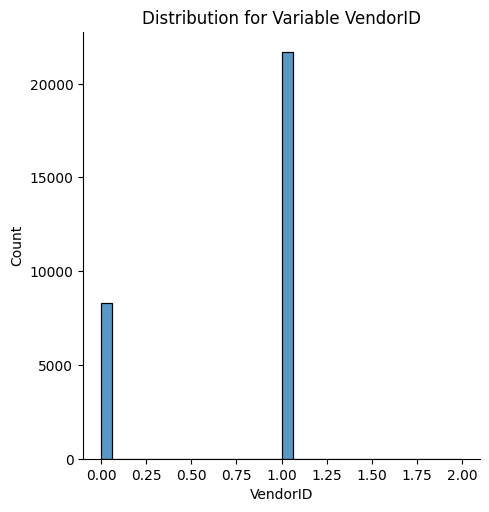

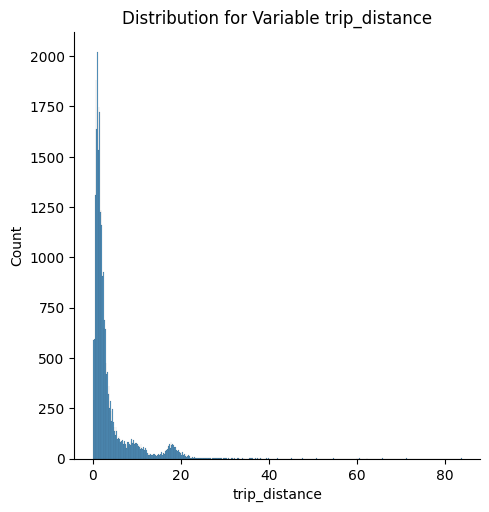

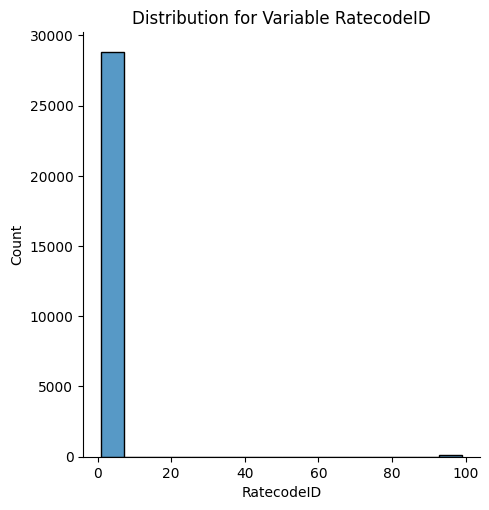

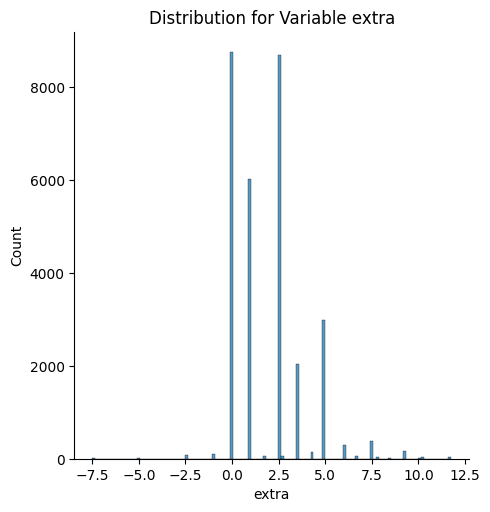

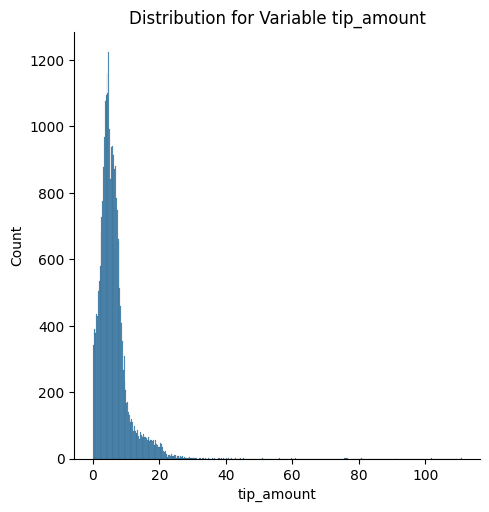

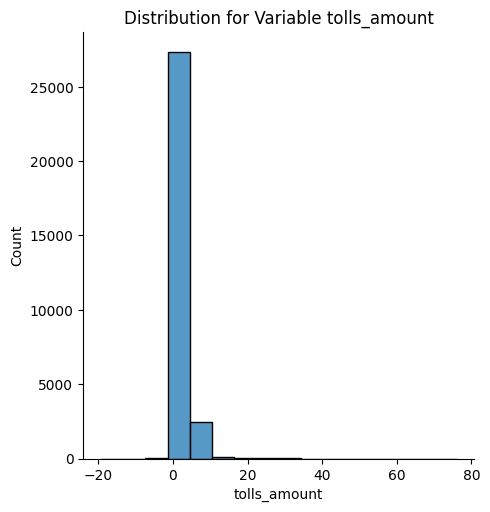

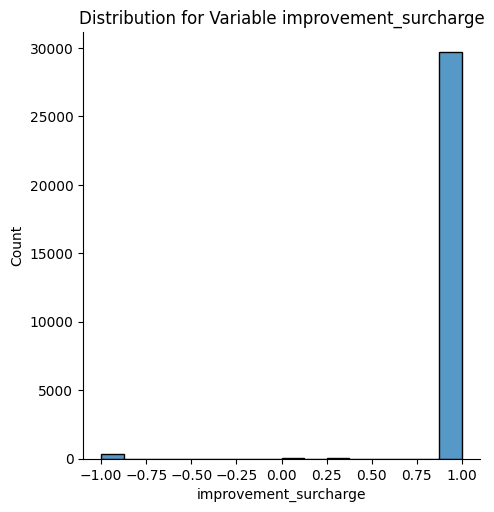

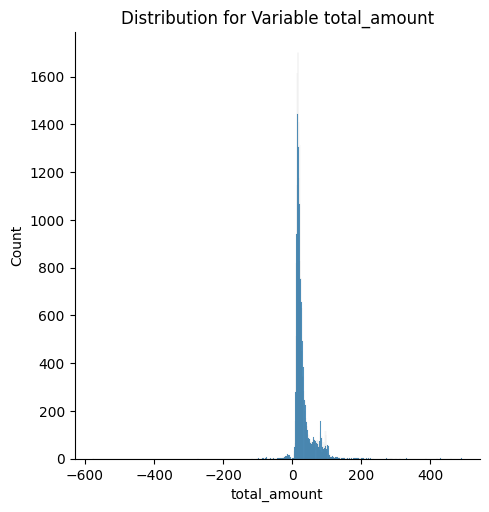

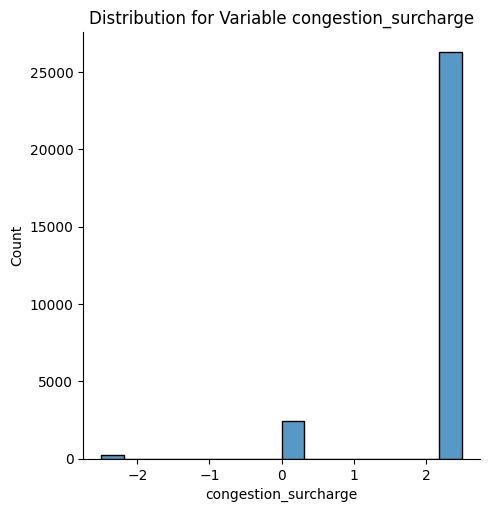

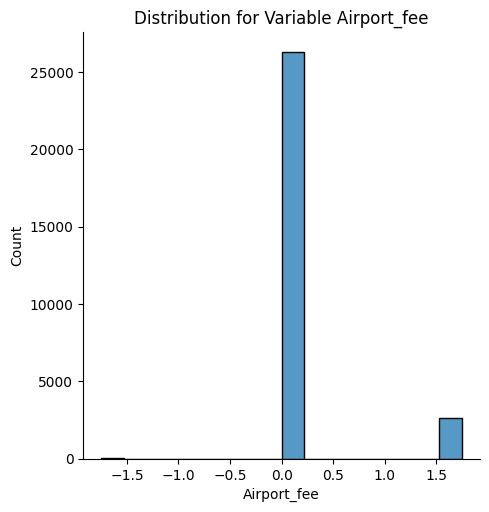

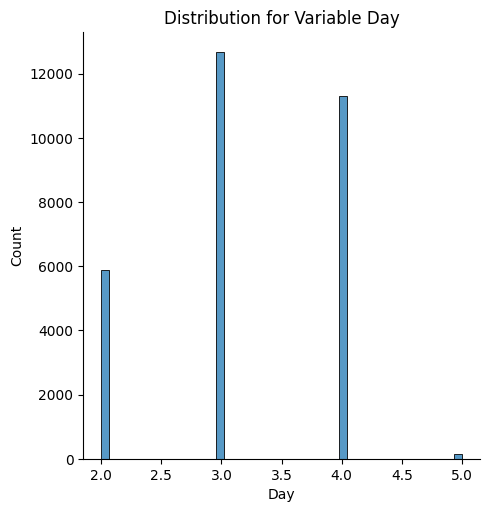

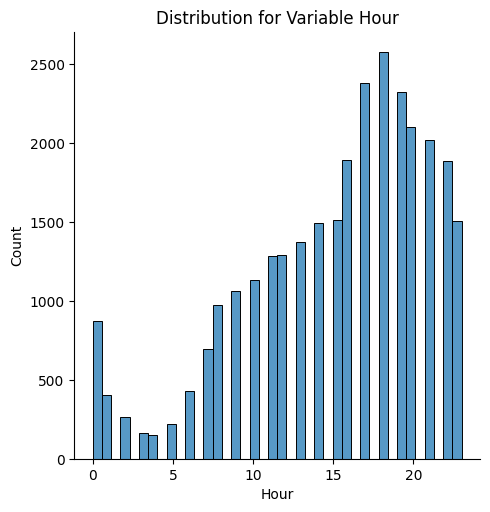

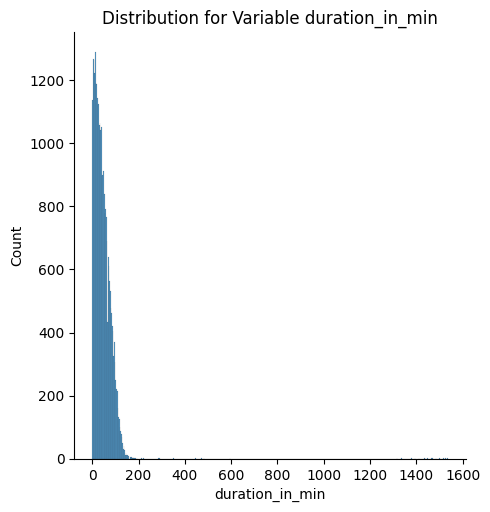

In [325]:
for i in num_col:
    sns.displot(data_eval[i])
    plt.title("Distribution for Variable "+i)
    plt.ylabel("Count")
    plt.show();

* trip distance,tip amount,duration are highly right skewed, which could lead to poor performance of the training model, need to check their skewness value and reduce if necessary.

# splitting,Imputing Missing values and scaling

In [326]:
X=data_t.drop(columns='total_amount',axis=1)
y=data_t['total_amount'].copy()
X_train,X_eval,y_train,y_eval=train_test_split(X,y,test_size=0.2,random_state=42,shuffle=True)

In [327]:
### sklearn api to impute the missing data
sime=SimpleImputer(missing_values=np.nan,strategy='median')
sim=SimpleImputer(missing_values=np.nan,strategy='mean')
simo=SimpleImputer(missing_values=np.nan,strategy='most_frequent')
knn=KNNImputer(missing_values=np.nan,n_neighbors=10)

ss=StandardScaler()
mabs=MaxAbsScaler()
mima=MinMaxScaler()
ohe=OneHotEncoder(handle_unknown='ignore')


In [328]:
#Numerical column to apply normaliztion
mima_col=X_train.columns.drop(['RatecodeID','payment_type','VendorID','Day','Hour'])

#categorical column to apply one hot encoder
cat_col.append('RatecodeID')
cat_col.append('VendorID')
cat_col.append('Day')
cat_col.append('Hour')



#### check for missing values in the triaing set

In [329]:
X_train.isna().sum()

VendorID                    0
trip_distance               0
RatecodeID               4841
payment_type                0
extra                       0
tip_amount                  0
tolls_amount                0
improvement_surcharge       0
congestion_surcharge     4841
Airport_fee              4841
Day                         0
Hour                        0
duration_in_min             0
dtype: int64

#### skewness check

In [330]:
X_train.skew(numeric_only=True,axis=0)

VendorID                  -1.007196
trip_distance            270.873591
RatecodeID                14.879357
extra                      1.094394
tip_amount                10.722601
tolls_amount               5.069855
improvement_surcharge     -9.797001
congestion_surcharge      -3.329144
Airport_fee                2.657063
Day                       -0.255690
Hour                      -0.823619
duration_in_min           16.104782
dtype: float64

* As can be seen trip distance is highly right skewed having a skewness of 270
* duration,ratecode id has larger skewness values


In [331]:
## to normalize higly right skewed attributes using a log(1+x) transform
def skewed_data(d):
    skew=['trip_distance','RatecodeID']
    sk=['duration_in_min','tip_amount']
    d[skew]=np.sign(d[skew])*np.log1p(np.abs(d[skew]))
    d[sk]=np.sign(d[sk])*(np.abs(d[sk])**(1/3))
    return d

In [332]:
X_train_e,X_eval_e,test_data_e=skewed_data(X_train),skewed_data(X_eval),skewed_data(test_data_t)

In [333]:
X_train_e.skew(numeric_only=True,axis=0)

VendorID                 -1.007196
trip_distance             1.065002
RatecodeID               10.920631
extra                     1.094394
tip_amount               -0.004460
tolls_amount              5.069855
improvement_surcharge    -9.797001
congestion_surcharge     -3.329144
Airport_fee               2.657063
Day                      -0.255690
Hour                     -0.823619
duration_in_min          -0.141637
dtype: float64

* **The skewness in the data is reduced and it is now ready for furthur processing**

# Model Training

In [334]:

class DataPreprocessor:
    def __init__(self, mima_col, cat_col):
        self.numerical_features = mima_col
        self.categorical_features = cat_col


        # Combine transformers using ColumnTransformer
        cat_pipe=Pipeline([('mode',simo),('ohe',ohe)])
        num_pipe=Pipeline([('mean',sim),('minmax',mima)])
        ct=ColumnTransformer([('cat',cat_pipe,self.categorical_features),('num',num_pipe,self.numerical_features)])

        #final_pipe=Pipeline([('ct',ct)])
        self.preprocessor = ct


    def fit(self,data):
        # Fit the preprocessing transformers
        self.preprocessor.fit(data)

    def transform(self, sdata):
        # Apply preprocessing and scaling
        transformed_data = self.preprocessor.transform(sdata)

        return transformed_data


In [335]:
preprocessor = DataPreprocessor(mima_col,cat_col)
preprocessor.fit(X_train)
X_train_t=preprocessor.transform(X_train_e)
X_eval_t=preprocessor.transform(X_eval_e)
test_X_t=preprocessor.transform(test_data_e)

### Cross validation
 the evaluation matix used here is cross validation with shufflesplit as cv and 'r2' as scoring parameter.
 the cross validated mean training and test scores are used for every model evaluation.

In [336]:
## the performance of the model is checked using cross validation with shufflesplit as cv
def train_regressor(estimator,X_t,y_t,name):

    cv = ShuffleSplit(n_splits=10,test_size=0.2, random_state=42)
    cvs=cross_validate(estimator,X_t,y_t,cv=cv,scoring='r2',n_jobs=-1,return_train_score=True,
                       return_estimator=True)
    train_score=cvs['train_score']
    test_score=cvs['test_score']
    print(f'average train score is : {train_score.mean()} +/- {train_score.std()}')
    print(f'average test score is : {test_score.mean()} +/- {test_score.std()}')


In [337]:
## fitting and prediction of the actual test data and writing it in a csv file 'submission.csv'
## This is the final submission file
def output(est,test):

    y_test=est.predict(test)
    y_test=pd.DataFrame(y_test)
    id=pd.DataFrame(np.arange(1,test_data.shape[0]+1))
    datasets=pd.concat((id,y_test),axis=1)
    datasets.columns=['ID','total_amount']
    datasets.to_csv('submission.csv',index=False)


In [338]:
## visualization of the predicted validation data against the actual validation data
def visualize_data(est,features,label):
    plt.figure(figsize=(8,8))
    y_pred=est.predict(features)
    dif=np.abs(label-y_pred)
    plt.scatter(label,y_pred)
    x=np.linspace(-400,400,num=100)
    y=x
    plt.plot(x,y,c='r')
    plt.xlabel('y_true')
    plt.ylabel('y_pred')
    plt.grid()
    plt.xlim((-400,400))
    plt.ylim((-400,400))
    plt.show()



In [339]:
def feature_selection(n):
    features=SelectKBest(f_regression,k=n)

    features.fit(X_train_t,y_train,)
    X_train_f=features.transform(X_train_t)
    X_eval_f=features.transform(X_eval_t)
    test_X_f=features.transform(test_X_t)
    return X_train_f,X_eval_f,test_X_f

## Decision Tree

In [340]:
dt=DecisionTreeRegressor(random_state=42)
l=np.linspace(10,X_train_t.shape[1],num=20,dtype=int)

score=[]
for n in l:
    X_train_f,X_eval_f,test_X_f=feature_selection(n)
    dt.fit(X_train_f,y_train)
    score.append(dt.score(X_eval_f,y_eval))


* fitting a bunch of decsion trees against a list of best features to see what number of best selected features give optimum score.

In [341]:
d={}
j=0
for i in l:
    d[i]=score[j]
    j+=1
d

{10: 0.899567047207411,
 12: 0.9138927809840673,
 14: 0.9202334986522583,
 16: 0.9216203459404727,
 18: 0.9199470820521336,
 20: 0.9240028049585925,
 22: 0.919653771427171,
 24: 0.9151743667237355,
 26: 0.9172807453933605,
 28: 0.9142284398113696,
 31: 0.9172954442049118,
 33: 0.9183823772738023,
 35: 0.925099765825702,
 37: 0.9233745763224697,
 39: 0.924767995303793,
 41: 0.9260257560007967,
 43: 0.9244124349783368,
 45: 0.923080703838566,
 47: 0.9219961322219032,
 50: 0.9221735952358681}

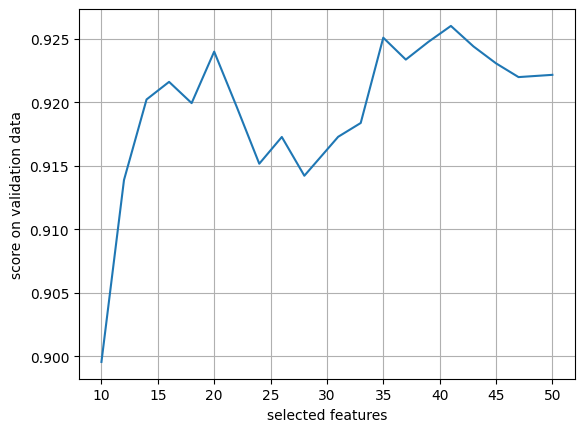

In [342]:
plt.plot(l,score)
plt.xlabel('selected features')
plt.ylabel('score on validation data');
plt.grid()

* As can be seen from the scores as well as the above plot, the best score is obtained when the no of best selected features is 41

In [347]:
features=SelectKBest(f_regression,k=41)
features.fit(X_train_t,y_train)

pickle.dump(features,open('scaled_model.pkl','wb'))

In [ ]:
#scale=pickle.load(open('scaled_model.pkl','rb'))

In [348]:

X_train_t=features.transform(X_train_t)
X_eval_t=features.transform(X_eval_t)
test_t=features.transform(test_X_t)

### decision tree with hyperparameter tuning

In [ ]:
dt=DecisionTreeRegressor(random_state=42)

params={'min_samples_split':[6,8,10,12,15],
       'max_depth':[5,10,15,20]}
gv=GridSearchCV(dt,param_grid=params,cv=5,n_jobs=-1)
gv.fit(X_train_t,y_train)

train_regressor(gv.best_estimator_,X_train_t,y_train,'decision tree')

In [ ]:
#pickle.dump(gv.best_estimator_, open('decision_tree.pkl', 'wb'))

## Random Forest

In [ ]:
## Random forest regressor trained with hyperparameter tuning using gridsearch cv

rfr=RandomForestRegressor(random_state=42,)
params={'max_depth':[5,10,15,20],
       'min_samples_split':[6,8,10,12]}
gv2=GridSearchCV(rfr,param_grid=params,cv=5,n_jobs=-1,scoring='r2')
gv2.fit(X_train_t,y_train)

train_regressor(gv2.best_estimator_,X_train_t,y_train,'random forest')


In [ ]:
#pickle.dump(gv2.best_estimator_, open('randomforest.pkl', 'wb'))

## K nearest neighbors

In [ ]:
## KNN regressor trained with hyperparameter tuning using gridsearch cv
'''
from sklearn.neighbors import KNeighborsRegressor
knn=KNeighborsRegressor()
params={'n_neighbors':[5,10,15,],'leaf_size':[5,10,20,30,],'weights':['uniform','distance']}
gv3=GridSearchCV(knn,param_grid=params,cv=5,n_jobs=-1,scoring='r2')
gv3.fit(X_train_t,y_train)
train_regressor(gv3.best_estimator_,X_train_t,y_train,'KNN')
'''

### SVM

In [ ]:
'''
from sklearn.svm import LinearSVR,SVR,NuSVR
lsvr=LinearSVR()
lsvr.fit(X_train_t,y_train)
print(lsvr.score(X_train_t,y_train))
print(lsvr.score(X_eval_t,y_eval))
'''

## Boosting

### Adaboost regressor

In [ ]:
'''
from sklearn.ensemble import AdaBoostRegressor
ab=AdaBoostRegressor(random_state=42,)
params={'n_estimators':[50,100,200,500],}
gv_ab=GridSearchCV(ab,param_grid=params,cv=5,n_jobs=-1,scoring='r2',)
gv_ab.fit(X_train_t,y_train)
train_regressor(gv_ab.best_estimator_,X_train_t,y_train,'adaboost')
'''

### XGBoost Regressor

In [349]:
from xgboost import XGBRegressor
xgb=XGBRegressor(n_jobs=-1)
param={'n_estimators':[40,60,75,100,],'max_leaves':[2,4,8,12]}
gv_xgb=GridSearchCV(xgb,param_grid=param,cv=5,n_jobs=-1)
gv_xgb.fit(X_train_t,y_train)
train_regressor(gv_xgb.best_estimator_,X_train_t,y_train,'XGB')

average train score is : 0.9506629171873424 +/- 0.0026283162650073276
average test score is : 0.9170791643496934 +/- 0.01160917353594929


In [350]:
pickle.dump(gv_xgb.best_estimator_, open('xgb.pkl', 'wb'))

## Bagging

In [ ]:
from sklearn.ensemble import BaggingRegressor
br=BaggingRegressor(estimator=gv.best_estimator_,n_jobs=-1,random_state=42,)
param={'n_estimators':[10,20,30,40,50],}
gv_br=GridSearchCV(br,param_grid=param,cv=5,n_jobs=-1)
gv_br.fit(X_train_t,y_train)
train_regressor(gv_br,X_train_t,y_train,'bagging')

In [ ]:
#pickle.dump(gv_br.best_estimator_, open('bagging.pkl', 'wb'))

## Multilayer Perceptron

In [ ]:
'''
from sklearn.neural_network import MLPRegressor
ml=MLPRegressor()
ml.fit(X_train_t,y_train)
train_regressor(ml,X_train_t,y_train,'mlp')
'''

In [ ]:
#pickle.dump(ml, open('mlpreg.pkl', 'wb'))

# Highlights from the data

* In this project all the features were extensively researched using various statistical techniques which involve descriptive as well as Inferential techniques.e.g- chi2 goodness test was performed to see correlation between store and forward flag and the label vector.

* some features which are thought to be relevant in real world are found having very low(~5-7%) importance in the output.e.g- passenger count,day of the week, pick up hours etc.

* The negative values(which are by intuition should be positive) as well as outliers in all the features were kept as it is,beacuse removing them or making them positive significantly affects the model performance in a negative way.

* the skewness minimization of some parameters which mostly have outliers proved to be an effective strategy as it counters the outliers somewhat.

* Finally, more study and research into the features could give furthur information about how features could be combined or engineered to give even better predictions.


In [ ]:
output(gv_xgb,test_X_t)

# Final Observations

* The models with best training scores are given by Decision tree,Random forest,bagging and xgb boost.
* As it is quite evident that tree based methods and tree based ensemble methods performs best the current datasets.
* three best performing models are Bagging,random forest and xgboost with xgboost being the best in predicting the data.
* The traing and test scores given by the xgboost
* Furthur fine tunning could be experimented with these models and it will be the next goal of this project
